<a href="https://colab.research.google.com/github/keyvany/decision-making-/blob/main/Catfinale10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install ANNArchy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.7/500.7 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ANNArchy: filename=ANNarchy-4.8.1-cp310-cp310-linux_x86_64.whl size=2051247 sha256=ae5aa59dbb06caed2c568751366d57f316f9ee40b5e1ca66b3588efdc28c4329
  Stored in directory: /root/.cache/pip/wheels/64/f3/08/809e6acd7efd84e66100ce60777c7a8773f3aead787fa2f967
Successfully built ANNArchy


In [1]:
pip install CompNeuroPy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.1/655.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.5/338.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 14.6 MB/s eta 0:00:00


In [4]:


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ANNarchy import (
    Neuron,
    Population,
    Projection,
    Synapse,
    setup,
    compile,
    Uniform,
    simulate,

)
import numpy as np
import random
from CompNeuroPy import CompNeuroMonitors, get_full_model, PlotRecordings


# Setup ANNarchy
setup(dt=1.0, num_threads=1)

# General parameters
ITdimension = 10
baseline_it = random.uniform(0.0, 0.1)
response_threshold = 0.5
nr_fish_presentations = 100

fish_list = [
    [
        [-1.0, 0.0, -1.0, 0.0],
        [-0.5, 0.0, 1.0, 1.0],
        [-0.5, 0.5, 0.5, 1.0],
        [-1.0, 0.5, 0.0, 1.0],
        [0.0, 1.0, 1.0, -1.0],
        [0.0, 1.0, 1.0, 0.0],
    ],
    [
        [1.0, 0.0, -1.0, 0.0],
        [0.0, -1.0, -1.0, 0.0],
        [0.5, 0.0, 0.0, 1.0],
        [0.0, -1.0, 1.0, 0.0],
        [1.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0],
    ],
]
feature_name_list = ["DF", "TF", "VF", "MA"]


# define the durations of the events
trial_duration = 200
dopamine_input_duration = 300
deactivate_input_duration = 30
calcium_trace_decline_duration = 100

# Set the dopamine condition
max_dopa = 1.5
baseline_dopa = 0.1
baseline_snc = 0.1
min_dopa = 0.0
K_dip = 0.4


# Neuron models
# In Fran's version SaturatedNeuron=LinearNeuron and NormalizationNeuron=LinearNeuron and LinearNeuronPFC=LinearNeuron
LinearNeuron = Neuron(
    parameters="""
        tau = 20.0
        baseline = 0.0
        noise = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = sum(exc) - sum(inh) + baseline + noise*Uniform(-1.0,1.0)
        r = pos(mp)
    """,
)

DopamineNeuron = Neuron(
    parameters="""
        tau = 20.0
        firing = 0
        inhibition = 0.0
        baseline = 0.0
    """,
    equations="""
        ex_in = if (sum(exc)>0): 1 else: 0
        s_inh = sum(inh)
        aux = if (firing>0): (ex_in)*(pos(1.0-baseline-s_inh) + baseline) + (1-ex_in)*(-10*sum(inh)+baseline)  else: baseline
        tau*dmp/dt + mp =  aux
        r = if (mp>0.0): mp else: 0.0
    """,
)

InputNeuron = Neuron(
    parameters="""
        tau = 1.5
        baseline = 0.0
    """,
    equations="""
        tau*dmp/dt + mp = baseline
        baseline_rec = baseline
        r = if (mp>0.0): mp else: 0.0
    """,
)

# Synapse models
# ?? population?
PostCovariance = Synapse(
    parameters="""
        tau = 1000.0
        tau_alpha = 10.0
        regularization_threshold = 1.0
        threshold_post = 0.0
        threshold_pre = 0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha =  pos(post.mp - regularization_threshold)


        trace = (pre.r - mean(pre.r) - threshold_pre) * pos(post.r - mean(post.r) - threshold_post)
    delta = (trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post)*w)
        tau*dw/dt = delta : min=0
   """,
)

ReversedSynapse = Synapse(
    parameters="""
        reversal = 1.0
    """,
    psp="""
        w*pos(reversal-pre.r)
    """,
)

# DA_typ = 1  ==> D1 type  DA_typ = -1 ==> D2 type
DAPostCovarianceNoThreshold = Synapse(
    parameters="""
        tau=1000.0
        tau_alpha=10.0
        regularization_threshold=1.0
        baseline_dopa = 0.1
        K_burst = 1.0
        K_dip = 0.4
        DA_type = 1
        threshold_pre=0.0
        threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  + alpha = pos(post.mp - regularization_threshold)
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(post.r -  mean(post.r) - threshold_post) * (pre.r - mean(pre.r) - threshold_pre)

    condition_0 = if (trace>0.0) and (w >0.0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: condition_0*DA_type*K_dip*dopa_sum



        delta = (dopa_mod* trace - alpha*pos(post.r - mean(post.r) - threshold_post)*pos(post.r - mean(post.r) - threshold_post))
        tau*dw/dt = delta : min=0
    """,
)

# Excitatory synapses STN -> GPi
DAPreCovariance_excitatory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt  = pos( post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (post.r - mean(post.r) - threshold_post)
        aux = if (trace<0.0): 1 else: 0
        dopa_mod = if (dopa_sum>0): K_burst * dopa_sum else: K_dip * dopa_sum * aux
        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0


    """,
)

# Inhibitory synapses GPi -> GPi and STRD2 -> GPe
DAPreCovariance_inhibitory = Synapse(
    parameters="""
    tau=1000.0
    tau_alpha=10.0
    regularization_threshold=1.0
    baseline_dopa = 0.1
    K_burst = 1.0
    K_dip = 0.4
    DA_type= 1
    threshold_pre=0.0
    threshold_post=0.0
    """,
    equations="""
        tau_alpha*dalpha/dt = pos( -post.mp - regularization_threshold) - alpha
        dopa_sum = 2.0*(post.sum(dopa) - baseline_dopa)

        trace = pos(pre.r - mean(pre.r) - threshold_pre) * (mean(post.r) - post.r  - threshold_post)
        aux = if (trace>0): 1 else: 0

        dopa_mod = if (DA_type*dopa_sum>0): DA_type*K_burst*dopa_sum else: aux*DA_type*K_dip*dopa_sum

        delta = dopa_mod * trace - alpha * pos(trace)
        tau*dw/dt = delta : min=0
    """,
)

DAPrediction = Synapse(
    parameters="""
        tau = 100000.0
        baseline_dopa = 0.1
   """,
    equations="""
       aux = if (post.sum(exc)>0): 1.0 else: 3.0
       delta = aux*(post.r - baseline_dopa)*pos(pre.r - mean(pre.r))
       tau*dw/dt = delta : min=0
   """,
)


# Populations
# IT Input
IT = Population(name="IT", geometry=(
    ITdimension, ITdimension), neuron=InputNeuron)
IT.tau = 10.0
IT.baseline = baseline_it

# FEF Input
FEF = Population(name="FEF", geometry=(
    ITdimension, ITdimension), neuron=InputNeuron)
FEF.tau = 10.0
FEF.baseline = baseline_it

# Lateral SNr
SNr = Population(name="SNr", geometry=2, neuron=LinearNeuron)
SNr.tau = 10.0
SNr.noise = 0.0
SNr.baseline = 0

# Reward Input
Reward_Layer = Population(name="Reward_Layer", geometry=1, neuron=InputNeuron)
Reward_Layer.tau = 1.0

# PFC_MTL
MTL = Population(name="PFC_MTL", geometry=(4, 9), neuron=LinearNeuron)
MTL.tau = 100.0
MTL.noise = 0.0
MTL.baseline = 0.0

# SNc
SNc = Population(name="SNc", geometry=1, neuron=DopamineNeuron)
SNc.tau = 10.0
SNc.firing = 0.0
SNc.baseline = baseline_snc

# Striatum direct pathway
StrD1 = Population(name="StrD1", geometry=(4, 4), neuron=LinearNeuron)
StrD1.tau = 10.0
StrD1.noise = 0.0
StrD1.baseline = 0.4

# Striatum indirect pathway
StrD2 = Population(name="StrD2", geometry=(4, 4), neuron=LinearNeuron)
StrD2.tau = 10.0
StrD2.noise = 0.0
StrD2.baseline = 0.4

# Striatum feedback pathway
StrThal = Population(name="StrThal-PFC", geometry=2, neuron=LinearNeuron)
StrThal.tau = 10.0
StrThal.noise = 0.0
StrThal.baseline = 0.4

# SNr
GPi = Population(name="GPi", geometry =2, neuron=LinearNeuron)
GPi.tau = 10.0
GPi.noise = 0.0
GPi.baseline = 0.0

# STN
STN = Population(name="STN", geometry = (4,4), neuron=LinearNeuron)
STN.tau = 10.0
STN.noise = 0.0
STN.baseline = 0.0

# GPe
GPe = Population(name="GPe", geometry = 2, neuron=LinearNeuron)
GPe.tau = 10.0
GPe.noise = 0.0
GPe.baseline = 0.0

# VA
VA = Population(name="VA-PFC", geometry=2, neuron=LinearNeuron)
VA.tau = 10.0
VA.noise = 0.0001
VA.baseline = 0.0

# PM
PM = Population(name="PM", geometry = 2, neuron=LinearNeuron)
PM.tau = 10.0
PM.noise = 0.0
PM.noise=0.0
#Projections#Projections

# Projections
ITMTL = Projection(pre=IT, post=MTL, target="exc", synapse=PostCovariance)
ITMTL.connect_all_to_all(weights=Uniform(0.2, 0.4))  # Normal(0.3,0.1) )
ITMTL.tau = 10
ITMTL.regularization_threshold = 3.5
ITMTL.tau_alpha = 1.0
ITMTL.baseline_dopa = baseline_dopa
ITMTL.threshold_post = 0.0
ITMTL.thrshold_pre = 0.15




MTLVA_11 = Projection(pre=MTL[0:8], post=VA[0], target="exc")
MTLVA_11.connect_all_to_all(weights=0.15)
MTLVA_22 = Projection(pre=MTL[8:16], post=VA[1], target="exc")
MTLVA_22.connect_all_to_all(weights=0.15)


IT_StrD1 = Projection(
    pre=IT, post=StrD1, target="exc", synapse=DAPostCovarianceNoThreshold
)
IT_StrD1.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_StrD1.tau = 75.0
IT_StrD1.regularization_threshold = 1.0
IT_StrD1.tau_alpha = 1.0
IT_StrD1.baseline_dopa = baseline_dopa
IT_StrD1.K_dip = 0.4
IT_StrD1.K_burst = 1.0
IT_StrD1.DA_type = 1
IT_StrD1.threshold_pre = 0.15

IT_StrD2 = Projection(
    pre=IT, post=StrD2, target="exc", synapse=DAPostCovarianceNoThreshold
)
IT_StrD2.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_StrD2.tau = 75.0
IT_StrD2.regularization_threshold = 1.0
IT_StrD2.tau_alpha = 1.0
IT_StrD2.baseline_dopa = baseline_dopa
IT_StrD2.K_dip = 0.4
IT_StrD2.K_burst = 1.0
IT_StrD2.DA_type = -1
IT.threshold_pre = 0.15

IT_STN = Projection(pre=IT, post=STN, target="exc",
                    synapse=DAPostCovarianceNoThreshold)
IT_STN.connect_all_to_all(weights=Uniform(0, 0.3))  # Normal(0.15,0.15))
IT_STN.tau = 75.0
IT_STN.regularization_threshold = 1.0
IT_STN.tau_alpha = 1.0
IT_STN.baseline_dopa = baseline_dopa
IT_STN.K_dip = 0.4
IT_STN.K_burst = 1.0
IT_STN.DA_type = 1
IT_STN.threshold_pre = 0.15

Reward_LayerSNc = Projection(pre=Reward_Layer, post=SNc, target="exc")
Reward_LayerSNc.connect_all_to_all(weights=1.0)

VAMTL_11 = Projection(pre=VA[0], post=MTL[0:8], target="exc")
VAMTL_11.connect_all_to_all(weights=0.35)
VAMTL_22 = Projection(pre=VA[1], post=MTL[8:16], target="exc")
VAMTL_22.connect_all_to_all(weights=0.35)

VAPM = Projection(pre=VA, post=PM, target="exc")
VAPM.connect_one_to_one(weights=1.0)

StrD1StrD1 = Projection(pre=StrD1, post=StrD1, target="inh")
StrD1StrD1.connect_all_to_all(weights=0.3)

STNSTN = Projection(pre=STN, post=STN, target="inh")
STNSTN.connect_all_to_all(weights=0.3)

MTLMTL = Projection(pre=MTL, post=MTL, target="inh")
MTLMTL.connect_all_to_all(weights=0.1)

PMPM = Projection(pre=PM, post=PM, target="inh")
PMPM.connect_all_to_all(weights=1.0)

StrD2StrD2 = Projection(pre=StrD2, post=StrD2, target="inh")
StrD2StrD2.connect_all_to_all(weights=0.3)

StrThalStrThal = Projection(pre=StrThal, post=StrThal, target="inh")
StrThalStrThal.connect_all_to_all(weights=0.3)

GPi_GPi = Projection(pre=GPi, post=GPi, target="exc", synapse=ReversedSynapse)
GPi_GPi.connect_all_to_all(weights=1.5)

StrD1_GPi = Projection(
    pre=StrD1, post=GPi, target="inh", synapse=DAPreCovariance_inhibitory
)
StrD1_GPi.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
StrD1_GPi.tau = 50.0
StrD1_GPi.regularization_threshold = 1.0
StrD1_GPi.tau_alpha = 1.0
StrD1_GPi.baseline_dopa = baseline_dopa
StrD1_GPi.K_dip = 0.4
StrD1_GPi.threshold_post = 0.15
StrD1_GPi.DA_type = 1

STN_GPi = Projection(
    pre=STN, post=GPi, target="exc", synapse=DAPreCovariance_excitatory
)
STN_GPi.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
STN_GPi.tau = 50.0
STN_GPi.regularization_threshold = 2.6
STN_GPi.tau_alpha = 1.0
STN_GPi.baseline_dopa = baseline_dopa
STN_GPi.K_dip = 0.4
STN_GPi.thresholdpost = -0.15
STN_GPi.DA_type = 1

StrD2_GPe = Projection(
    pre=StrD2, post=GPe, target="inh", synapse=DAPreCovariance_inhibitory
)
StrD2_GPe.connect_all_to_all(weights=Uniform(0, 0.05))  # Normal(0.025,0.025))
StrD2_GPe.tau = 50.0
StrD2_GPe.regularization_threshold = 2.0
StrD2_GPe.tau_alpha = 1.0
StrD2_GPe.baseline_dopa = baseline_dopa
StrD2_GPe.K_dip = 0.4
StrD2_GPe.threshold_post = 0.15
StrD2_GPe.DA_type = -1



GPe_GPi = Projection(pre=GPe, post=GPi, target="inh")
GPe_GPi.connect_one_to_one(weights=1.5)

#FEF_SNr = Projection(pre=FEF, post=SNr, target="inh")
#FEF_SNr.connect_one_to_one(weights=1.5)

#SNr_VA = Projection(pre=SNr, post=VA, target="inh")
#SNr_VA.connect_one_to_one(weights=1.5)

GPe_GPi = Projection(pre=GPe, post=STN, target="inh")
GPe_GPi.connect_all_to_all(weights=1.5)

VAStr_Thal = Projection(pre=VA, post=StrThal, target="exc")
VAStr_Thal.connect_one_to_one(weights=1.0)

StrThal_GPe = Projection(pre=StrThal, post=GPe, target="inh")
StrThal_GPe.connect_one_to_one(weights=0.3)

StrThal_GPi = Projection(pre=StrThal, post=GPi, target="inh")
StrThal_GPi.connect_one_to_one(weights=0.3)

GPi_VA = Projection(pre=GPi, post=VA, target="inh")
GPi_VA.connect_one_to_one(weights=0.5)

SNc_StrD1 = Projection(pre=SNc, post=StrD1, target="dopa")
SNc_StrD1.connect_all_to_all(weights=1.0)

SNc_StrD2 = Projection(pre=SNc, post=StrD2, target="dopa")
SNc_StrD2.connect_all_to_all(weights=1.0)

SNc_GPi = Projection(pre=SNc, post=GPi, target="dopa")
SNc_GPi.connect_all_to_all(weights=0.000001)

SNc_STN = Projection(pre=SNc, post=STN, target="dopa")
SNc_STN.connect_all_to_all(weights=1.0)

SNc_GPe = Projection(pre=SNc, post=GPe, target="dopa")
SNc_GPe.connect_all_to_all(weights=1.0)

SNc_MTL = Projection(pre=SNc, post=MTL, target="dopa")
SNc_MTL.connect_all_to_all(weights=1.0)

SNc_VA = Projection(pre=SNc, post=VA, target="dopa")
SNc_VA.connect_all_to_all(weights=1.0)

VAPM = Projection(pre=VA, post=PM, target="exc")
VAPM.connect_all_to_all(weights=1.0)

#PMIT = Projection(pre=PM, post=IT, target="exc")
#PMIT.connect_all_to_all(weights=0.95)


compile()

ANNarchy 4.8 (4.8.1) on linux (posix).
Compiling ...  OK 


In [5]:
populations = get_full_model()["populations"]
print(populations)
kol=[]
poplist=[pop for pop in populations]
print(poplist)
all_performance_values=[]
mon_dict={""+pop:["r"] for pop in populations}
mon=CompNeuroMonitors(mon_dict)
populations = get_full_model()["populations"]

mon = CompNeuroMonitors(mon_dict)
print(mon_dict)

['IT', 'FEF', 'SNr', 'Reward_Layer', 'PFC_MTL', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'GPi', 'STN', 'GPe', 'VA-PFC', 'PM']
['IT', 'FEF', 'SNr', 'Reward_Layer', 'PFC_MTL', 'SNc', 'StrD1', 'StrD2', 'StrThal-PFC', 'GPi', 'STN', 'GPe', 'VA-PFC', 'PM']
{'IT': ['r'], 'FEF': ['r'], 'SNr': ['r'], 'Reward_Layer': ['r'], 'PFC_MTL': ['r'], 'SNc': ['r'], 'StrD1': ['r'], 'StrD2': ['r'], 'StrThal-PFC': ['r'], 'GPi': ['r'], 'STN': ['r'], 'GPe': ['r'], 'VA-PFC': ['r'], 'PM': ['r']}


In [79]:
def get_fish(fish_list, feature_name_list):
    """
    return a dictionary with features and feature values

    Args:
        fish_list: list
            list with all possible fishes consisting of 4 feature values
        feature_name_list: list
            list containing 4 strings, the names of the 4 features (the order corresponds to the order in fish_list)
    """
    input_1 = random.randint(0, 1)
    # print(input_1)
    input_11 = random.randint(
        0, 5
    )
   # input_11=0
    input_sacc = fish_list[input_1][input_11]
    # print(input_sacc)
    fish = dict(zip(feature_name_list, input_sacc))
    return fish
def get_true_category(fish):
    important_feature =  "DF"
    important_feature1= "TF"
    important_feature2= "VF"
    """
    returns the of a given fish based on a single feature
    """

    global cat
    str(cat)
    if fish in fish_list[0]:
       cat ="A"
    if fish in fish_list[1]:
       cat= "B"
  #  if fish[important_feature]  - fish[important_feature1] < 0.0:
       # cat = "A"

  #  if fish[important_feature] - fish[important_feature1] >= 0.0:
      #  cat = "B"
 #   if fish[important_feature] - fish[important_feature] == 0.0:
      # if fish[important_feature2]==0.0:
         # cat="B"
     #  else:
          #cat= "A"
    return cat
def select_input(feature_name, fish, IT, feature_name_list, baseline_default):
    """
    activates IT neurons based on the presented feature

    Args:
        feature_name: string
            name of the activated feature
        fish: dictionary
            dictionary containing the feature values for the fish features
        IT: ANNarchy population
            the IT population
        feature_name_list: list
            list containing 4 strings, the names of the 4 features (the order corresponds to the order in fish_list)
        baseline_default: float
            default baseline of IT
    """
    # set deafult baseline
    IT.baseline = baseline_default

    # feature name i.e. spatial position defines the group of IT neurons
    nr_IT_neurons = len(IT)
    nr_group_neurons = nr_IT_neurons // (len(feature_name_list))
    neuron_group_idx = feature_name_list.index(feature_name)
    neuron_group = IT[
        int(neuron_group_idx * nr_group_neurons): int(
            (neuron_group_idx + 1) * nr_group_neurons
        )
    ]

    # feature value defines which neurons of neuron group get active --> neuron groups are feature-value selective
    feature_value = fish[feature_name]
    activity_center_idx = ((feature_value - (-1)) /
                           (1 - (-1))) * (nr_group_neurons - 1)

    activity = gauss_1D(
        m=activity_center_idx,
        sig=nr_group_neurons / 10,
        size=nr_group_neurons,
        min=neuron_group.baseline[0],
    )

    # set the activity of the neuron group
    neuron_group.baseline = activity
def gauss_1D(m, sig, size, min):
    """
    returns a 1D gaussian array

    Args:
        m: float
            center/mean of the gaussian along the array indizes
        sig: float
            standard deviation in array indizes
        size: int
            size of the returned array
        min: float
            minimum value
    """
    return np.clip(np.exp(-((np.arange(size) - m) ** 2) / (2 * sig**2)), min, None)


def get_feature_order(feature_name_list):
    """
    return a list with feature names containing the presentation order of the fish features
    """
    idx_arr = np.arange(len(feature_name_list))
    feature_name_arr = np.array(feature_name_list)
    np.random.shuffle(idx_arr)
    return feature_name_arr[idx_arr].tolist()

In [59]:
fish_list = [
    [

    [-1.0,0.0,-1.0,0.0],
     [-1.0,0.0,1.0,1.0],
      [-0.5,0.5,0.0,0.0],
     [-1,0.5,0.0,1],
      [-0.5,-0.5,1.0,0.0],
       [-0.5,-1,0.0,1.0],
            [-1.0, 0.0, -1.0, 0.0],
        [-1.0, 0.0, 1.0, 1.0],
        [-0.5, 0.5, 0.0, 0.0],
        [-1, 0.5, 0.0, 1],
        [-0.5, -0.5, 1.0, 0.0],
        [-0.5, -1, 0.0, 1.0],
    ],
    [
                 [1.0,0.0,-1.0,0.0],
          [0.5,0,0.0,-1.0],
           [1,0.5,-1.0,0.0],
            [0.5,-0.5,0.0,-1.0],
             [0.5,1,0.0,1.0],
        [1.0, 0.0, -1.0, 0.0],
        [1.0, 0.0, 1.0, 0.0],
        [0.5, -0.5, 0.0, -1.0],
        [1, -0.5, 0.0, -1.0],
        [0.5, 0.5, 1.0, 0.0],
        [0.5, 1, 0.0, 1.0],
        [1.0,0.0,-1.0,0.0],


    ],
]
feature_name_list = ["DF", "TF", "VF", "MA"]
ll=[[],[]]

In [7]:
feature_name_list = ["DF", "TF", "VF", "MA"]
fish_list = [
    [
        [-1.0, 0.0, -1.0, 0.0],
        [-0.5, 0.0, 1.0, 1.0],
        [-0.5, 0.5, 0.5, 1.0],
        [0.0, 0.0, 0.5, 0.0],
        [0.0, 1.0, 1.0, -1.0],
        [0.0, 1.0, 1.0, 0.0],
    ],
    [
        [1.0, 0.0, -1.0, 0.0],
        [1.0, 0.0, 1.0, 0.0],
        [0.5, -0.5, 0.0, -1.0],
        [0.0, -1.0, 1.0, 0.0],
        [1.0, 1.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 1.0],
    ],
]

In [53]:
fish_list = [
    [
        [-1.0, -1.0, -1.0, 0.0],
        [-1.0, -1.0, 1.0, 1.0],
        [-1.0, -1.0, 0.5, 1.0],
        [-1.0, -1.0, 0.5, 0.0],
        [-1.0, -1.0, 1.0, -1.0],
        [-1.0, -1.0, 1.0, 0.0],
    ],
    [
        [1.0, 1.0, -1.0, 0.0],
        [1.0, 0.0, 1.0, 0.0],
        [0.5, -0.5, 0.0, -1.0],
        [0.0, -1.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 1.0],
    ],
]

In [80]:
response_threshold=0.05
consecutive_correct = 0
ll=[[],[]]
performance_percent=0
nr_fish_presentations=100
mylist=[]
trial_correctness_list=[]
for _ in range(nr_fish_presentations):
    # stop the presentation of fishes if 300 fishes were consecutively correctly classified
    if consecutive_correct == 300:

        break

    # each fish is represented by 4 features which are presented sequentially (I think in random order)
    # --> here the function get_features() somehow returns a list with the 4 features for a given fish
    # and the function get_category returns the corresponding category of the fish
    fish = get_fish(fish_list, feature_name_list)
    feature_order = get_feature_order(feature_name_list)
    category_true = get_true_category(fish)
    mon.reset
    # loop over all features of the fish
    for feature_name in feature_order:
        mon.start()
        # select the input = activate one feature of the fish in IT or MTL (the manuscript says IT)
        # I think, based on the feature you have to activate specific neurons in the IT
        # this is done by the select_input function
        select_input(feature_name, fish, IT, feature_name_list, baseline_it)

        # simulate the duration of the trial / how long the feature is presented
        simulate(trial_duration)

        # get the response from the PM population --> the PM neuron which is most active = selected category
        # there are only two PM neurons --> it selects either category A or B (0 or 1)
        response_value = np.max(PM.r)
        response_idx = np.argmax(PM.r)

        # I think, in your code, the response is only evaluated if it is high enough --> wait until it's high enough or all features have been presented
        # I think, if all features of a fish have been presented (the presentation of the fish is complete) the model should do a response
        if response_value > response_threshold or feature_name == feature_order[-1]:
            # if response was made --> deactivate the input (the manuscript says, this takes 30 ms)
            IT.baseline = baseline_it
            simulate(deactivate_input_duration)

            # check if the response is equal to the category of the given fish
            category_selected = ["A", "B"][response_idx]
            print(
                f"category_true: {category_true}; category_selected: {category_selected}; after {feature_order.index(feature_name)+1} features",
            )
            print(f"{_}th fish is:\n{fish}")
            print(feature_order)

            if category_selected == category_true:
                if category_selected=="A": ll[0].append(fish)
                elif category_selected=="B": ll[1].append(fish)
                # correct response
                # therefore, activate PPTN, here called Reward_Layer
                Reward_Layer.baseline = 1
                # count the consecutive correct decisions, to stop after 300 consecutive correct decisions
                consecutive_correct += 1
                trial_correctness_list.append(1)
            else:
                # incorrect response
                # therefore, do not activate PPTN
                Reward_Layer.baseline = 0
                # reset the consecutive correct decisions
                consecutive_correct = 0
                trial_correctness_list.append(0)
              # simulate the dopamine input by activating SNc
            SNc.firing = 1

            simulate(dopamine_input_duration)
            # stop the dopamine presentation
            #Reward_Layer.baseline = 0
            SNc.firing = 0

            simulate(calcium_trace_decline_duration)
            # end/break the presentation of the fish --> next fish will be presented
            # let the calcium traces decline to zero
            #simulate(calcium_trace_decline_duration)
            mon.pause()
            mon.reset()


### calculate the performance in percent of the last 100 trials
            if _>=50:

              performance_percent = sum(trial_correctness_list[-100:])/100
              mylist.append(performance_percent)
            break

              #mon_dict["pop;PFC_MTL"]=["r", "baseline_rec"]
print(performance_percent)

category_true: A; category_selected: A; after 4 features
0th fish is:
{'DF': 0.5, 'TF': 1, 'VF': 0.0, 'MA': 1.0}
['TF', 'DF', 'MA', 'VF']
category_true: A; category_selected: A; after 4 features
1th fish is:
{'DF': -1, 'TF': 0.5, 'VF': 0.0, 'MA': 1}
['DF', 'MA', 'TF', 'VF']
category_true: A; category_selected: A; after 4 features
2th fish is:
{'DF': -0.5, 'TF': 0.5, 'VF': 0.0, 'MA': 0.0}
['DF', 'MA', 'VF', 'TF']
category_true: A; category_selected: B; after 4 features
3th fish is:
{'DF': -1, 'TF': 0.5, 'VF': 0.0, 'MA': 1}
['VF', 'MA', 'TF', 'DF']
category_true: A; category_selected: A; after 4 features
4th fish is:
{'DF': 1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0}
['DF', 'TF', 'MA', 'VF']
category_true: A; category_selected: B; after 4 features
5th fish is:
{'DF': 0.5, 'TF': 0, 'VF': 0.0, 'MA': -1.0}
['VF', 'TF', 'MA', 'DF']
category_true: A; category_selected: B; after 1 features
6th fish is:
{'DF': 1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0}
['MA', 'TF', 'VF', 'DF']
category_true: A; category

In [9]:
recordings1=mon.get_recordings()
recording_times1 = mon.get_recording_times()
#recordings1,recording_times1=mon.get_recordings_and_clear()
#recordings2,recording_times2=mon.get_recordings_and_clear()

In [ ]:
for chunk in range(11,12):
        ### using plot_recordings which plots the recordings of one chunk
        PlotRecordings(
            figname=f"monitor_recordings_1_chunk{chunk}.png",
            recordings=recordings1,
            #recording_times=recording_times1,
            recording_times=recording_times1,
            shape=(2,2),
            plan={
                "position": [1,2,3,4],
                "compartment": ["IT", "StrD1","StrD2","STN"],
                "variable": ["r", "r", "r", "r"],
                "format": ["matrix", "matrix", "matrix","matrix"],
            },
            chunk=chunk,

        )
        plt.savefig(f"pw3{chunk}.png")
        print(chunk)

Generate fig monitor_recordings_1_chunk11.png... Done

11


<Figure size 640x480 with 0 Axes>

In [ ]:
for chunk in range(15,16):


   PlotRecordings(
            figname=f"mon_recordings_1_chunk{chunk}.png",
            recordings=recordings1,
            recording_times=recording_times1,
            shape=(2,2),
            plan={
                "position": [1,2,3,4],
                "compartment": ["GPi","VA-PFC", "PM", "SNc"],
                "variable": ["r", "r", "r", "r"],
                "format": ["matrix", "matrix", "matrix", "line"],
            },
            chunk=chunk,


   )
   plt.savefig(f"pw3{chunk}.png")
   print(chunk)

Generate fig mon_recordings_1_chunk15.png... Done

15


<Figure size 640x480 with 0 Axes>

In [ ]:
for chunk in range(15,16):


   PlotRecordings(
            figname=f"trecordings_1_chunk{chunk}.png",
            recordings=recordings1,
            recording_times=recording_times1,
            shape=(2,2),
            plan={
                "position": [1,2,3,4],
                "compartment": ["GPi","VA-PFC", "PM", "SNc"],
                "variable": ["r", "r", "r", "r"],
                "format": ["line", "line", "line", "line"],
            },
            chunk=chunk,


   )
   plt.savefig(f"pw3{chunk}.png")
   print(chunk)

Generate fig trecordings_1_chunk15.png... Done

15


<Figure size 640x480 with 0 Axes>

In [ ]:
for chunk in range(24,25):


   PlotRecordings(
            figname=f"wrecordings_1_chunk{chunk}.png",
            recordings=recordings1,
            recording_times=recording_times1,
            shape=(2,1),
            plan={
                "position": [1,2],
                "compartment": ["PFC_MTL","GPi"],
                "variable": ["r", "r"],
                "format": ["matrix", "line"],
            },
            chunk=chunk,


   )
   plt.savefig(f"pw3{chunk}.png")
   print(chunk)

Generate fig wrecordings_1_chunk24.png... Done

24


<Figure size 640x480 with 0 Axes>

In [ ]:
x=recordings1
x[0]['IT;r']

array([[0.00352842, 0.00352842, 0.00352842, ..., 0.00352842, 0.00352842,
        0.00352842],
       [0.00688041, 0.00688041, 0.00688041, ..., 0.00688041, 0.00688041,
        0.00688041],
       [0.01006481, 0.01006481, 0.01006481, ..., 0.01006481, 0.01006481,
        0.01006481],
       ...,
       [0.07056835, 0.07056835, 0.07056835, ..., 0.07056835, 0.07056835,
        0.07056835],
       [0.07056835, 0.07056835, 0.07056835, ..., 0.07056835, 0.07056835,
        0.07056835],
       [0.07056835, 0.07056835, 0.07056835, ..., 0.07056835, 0.07056835,
        0.07056835]])

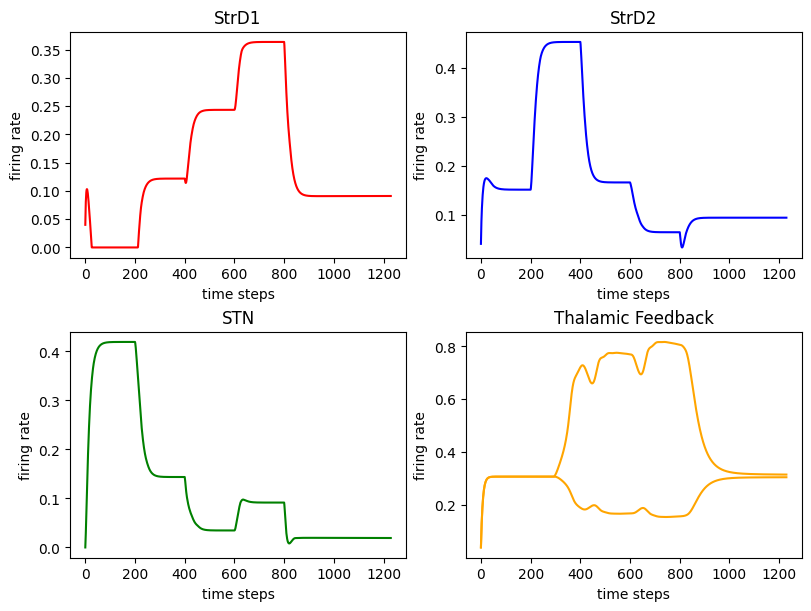

In [ ]:
x = recordings1
fig, ax = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
ax = ax.flatten()

# Plot Curves:

ax[0].plot(x[15]['StrD1;r'][:,4], color='red')
ax[0].set_title('StrD1')
ax[0].set_xlabel('time steps')
ax[0].set_ylabel('firing rate')

ax[1].plot(x[15]['StrD2;r'][:,14], color='blue')
ax[1].set_title('StrD2')
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('firing rate')

ax[2].plot(x[15]['STN;r'][:,14], color='green')
ax[2].set_title('STN')
ax[2].set_xlabel('time steps')
ax[2].set_ylabel('firing rate')

ax[3].plot(x[15]['StrThal-PFC;r'], color='orange')
ax[3].set_title('Thalamic Feedback')
ax[3].set_xlabel('time steps')
ax[3].set_ylabel('firing rate')


plt.show()

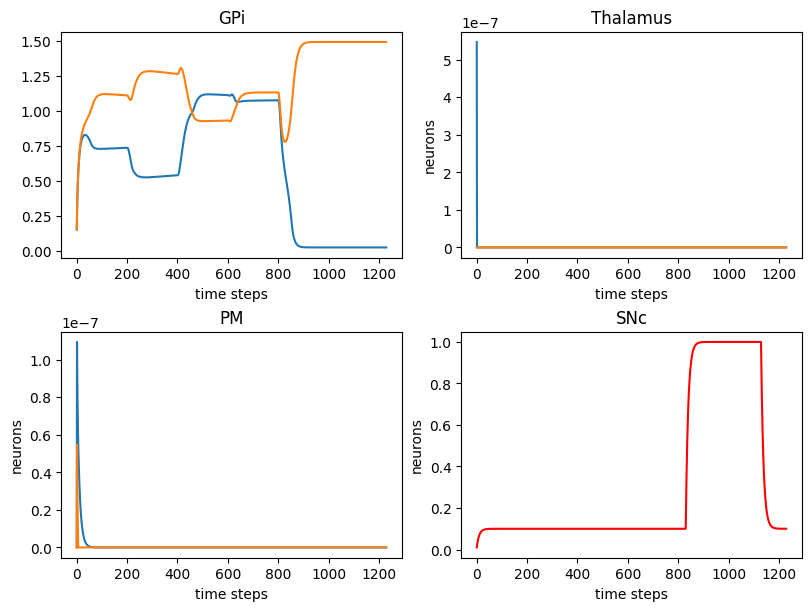

In [ ]:
x = recordings1
fig, ax = plt.subplots(2, 2, figsize=(8, 6), constrained_layout=True)
ax = ax.flatten()

# Plot Curves:

ax[0].plot(x[38]['GPi;r'])
ax[0].set_title('GPi')
ax[0].set_xlabel('time steps')



ax[1].plot(x[38]['VA-PFC;r'])
ax[1].set_title('Thalamus')
ax[1].set_xlabel('time steps')
ax[1].set_ylabel('neurons')

ax[2].plot(x[38]['PM;r'])
ax[2].set_title('PM')
ax[2].set_xlabel('time steps')
ax[2].set_ylabel('neurons')

ax[3].plot(x[38]['SNc;r'], color='red')
ax[3].set_title('SNc')
ax[3].set_xlabel('time steps')
ax[3].set_ylabel('neurons')
plt.show()

In [ ]:
x=recordings1
import numpy as np
for p in populations:
  for i in range(25):
     d = x[i][""+p+";r"]
     np.savetxt('data{}_{}.csv'.format(p,i), d, delimiter=',')

In [ ]:
import pandas as pd
dirpa=pd.read_csv('dataIT_21.csv')
print(dirpa)
dirp=pd.DataFrame(dirpa)
dirp.describe()
dota=[]
dota.append(dirp)

     7.551135237790451661e-04  7.551135237790451661e-04.1  \
0                    0.001435                    0.001435   
1                    0.002046                    0.002046   
2                    0.002597                    0.002597   
3                    0.003092                    0.003092   
4                    0.003538                    0.003538   
..                        ...                         ...   
824                  0.007551                    0.007551   
825                  0.007551                    0.007551   
826                  0.007551                    0.007551   
827                  0.007551                    0.007551   
828                  0.007551                    0.007551   

     7.551135237790451661e-04.2  7.551135237790451661e-04.3  \
0                      0.001435                    0.001435   
1                      0.002046                    0.002046   
2                      0.002597                    0.002597   
3              

In [ ]:
import pandas as pd
dirpaa=pd.read_csv('dataGPi_21.csv')
print(dirpaa)
dirpaa=pd.DataFrame(dirpaa)
dirpaa.describe()

     1.499999999999999944e-01  1.499999999999999944e-01.1
0                    0.261300                    0.261300
1                    0.347447                    0.347942
2                    0.416115                    0.417772
3                    0.471973                    0.475495
4                    0.518062                    0.524131
..                        ...                         ...
824                  0.000000                    1.494326
825                  0.000000                    1.494290
826                  0.000000                    1.494254
827                  0.000000                    1.494218
828                  0.000000                    1.494182

[829 rows x 2 columns]


,1.499999999999999944e-01,1.499999999999999944e-01.1
count,829.000000,829.000000
mean,0.181829,1.526373
std,0.281552,0.293585
min,0.000000,0.261300
25%,0.000000,1.318428
50%,0.000000,1.511615
75%,0.535845,1.589174
max,0.746610,2.014077


<ipython-input-33-a79b9991031e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[4].set_xticklabels([0, 200, 400, 600, 800, 1000])


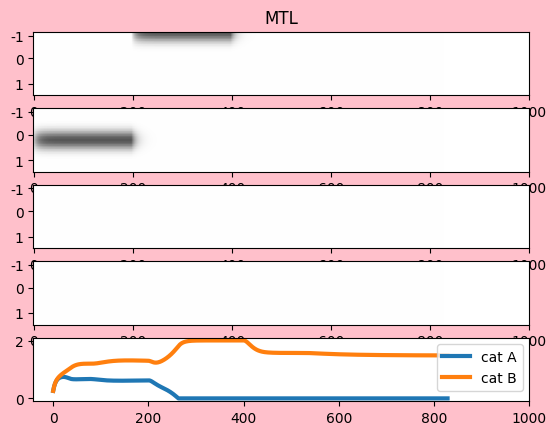

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plotGPiPaths2():

    MTLscale = [0.0, 1.5]
    GPiscale=[0.1,0.9]
    MTL_data = dirp.T
    GPi_0_data = dirpaa
    GPi_1_data = dirpaa.loc[1]
   # SNc_rate = np.loadtxt('C:/Users/yahya/OneDrive/Data/SNc_PM.txt')
    #MTL_data=np.rot90(MTL_data)
    fig, axs = plt.subplots(5, 1)
    fig.set_facecolor('pink')
    datapoints=[i for i,j in enumerate (MTL_data) ]
    for i in range(4):
     axes = axs[i]
     axes.imshow(MTL_data[i*25:(i+1)*25], aspect='auto', cmap='gist_yarg', vmin=MTLscale[0], vmax=MTLscale[1])
     axes.set_xticks([0, 200, 400, 600, 800, 1000])
     axes.set_xticklabels([0, 200, 400, 600, 800, 1000])
     axes.set_yticks([1, 10, 20])
     axes.set_yticklabels([-1, 0, 1])
     if i==0:
       axes.set_title('MTL')
       axes.set_xlabel('features_name[{i}]')



     dodo=np.mean(dirpaa)
    for label in zip(['cat A'], ['cat B']):
        axs[4].plot((GPi_0_data), label=label, linewidth=3)
        axs[4].set_xticklabels([0, 200, 400, 600, 800, 1000])
        axs[4].set_xticks([0, 200, 400, 600, 800, 1000])
        axs[4].legend()
        #axs[4].set_title('GPi-1')
    #axs[3].plot(dirpaa)
    #axs[3].set_xticklabels(np.arange(0, len(dirpaa)))
    #axs[3].set_title('GPi')

    plt.show()
    print(datapoints)
# Call the function with your desired values of t1 and t2
plotGPiPaths2()  # Example values for t1 and t2
print(len(dirpaa))

In [50]:
ll[1]

[{'DF': 1.0, 'TF': 1.0, 'VF': 0.0, 'MA': 0.0},
 {'DF': 1.0, 'TF': 1.0, 'VF': 0.0, 'MA': 0.0},
 {'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0},
 {'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0},
 {'DF': 1.0, 'TF': 1.0, 'VF': 0.0, 'MA': 0.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0},
 {'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 1.0, 'TF': 1.0, 'VF': 0.0, 'MA': 0.0},
 {'DF': 1.0, 'TF': 1.0, 'VF': 0.0, 'MA': 0.0},
 {'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 1.0, 'TF': 1.0, 'VF': 0.0, 'MA': 0.0}]

19


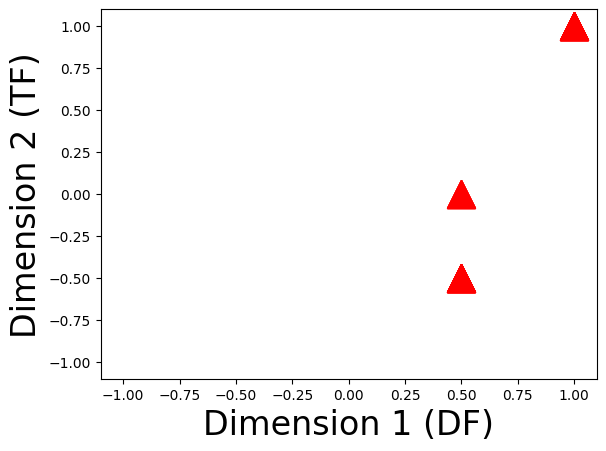

In [49]:

print(len(ll[1]))
for j in range(23):
   #plt.plot(al[j][0], al[j][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=20)
   plt.plot(ol[j][0], ol[j][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=20)
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 2 (TF)', fontsize=24)
plt.xlabel('Dimension 1 (DF)', fontsize=24)
plt.show()

In [30]:

ol=[]
al=[]
for k in range(25):
   al.append([ll[0][k]['DF'],ll[0][k]['TF']])

   ol.append([ll[1][k]['DF'],ll[1][k]['TF']])
for j in range(20):
   plt.plot(al[j][0], al[j][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=20)
   plt.plot(ol[j][0], ol[j][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=20)
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 2 (TF)', fontsize=24)
plt.xlabel('Dimension 1 (DF)', fontsize=24)
plt.show()

IndexError: list index out of range

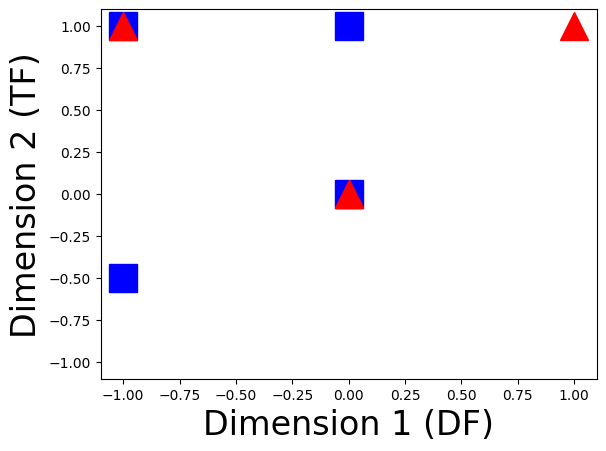

In [ ]:
import matplotlib.pyplot as plt

ExemplarC1 = fish_list[0]

# array from your data source
ExemplarC2 =fish_list[1]
 # array from your data source

plt.figure()
plt.plot(ExemplarC1[:][0], ExemplarC1[:][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=20)
plt.plot(ExemplarC2[:][0], ExemplarC2[:][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=20)
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 2 (TF)', fontsize=24)
plt.xlabel('Dimension 1 (DF)', fontsize=24)
plt.show()

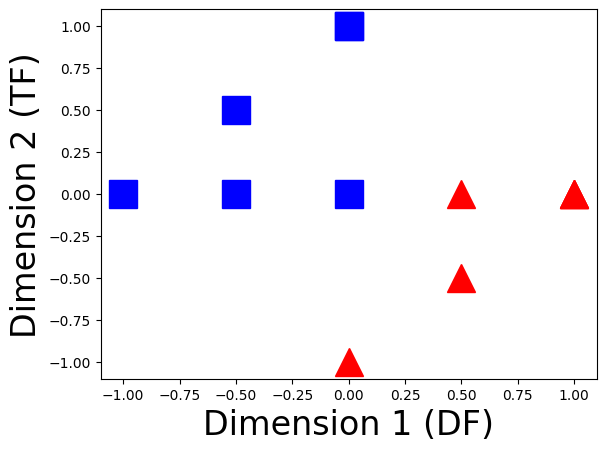

In [ ]:
plt.figure()
for j in range(len(ExemplarC1)):
   plt.plot(ExemplarC1[j][0], ExemplarC1[j][1], 's', markeredgecolor='b', markerfacecolor='b', markersize=20)
   plt.plot(ExemplarC2[j][0], ExemplarC2[j][1], '^', markeredgecolor='r', markerfacecolor='r', markersize=20)
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel('Dimension 2 (TF)', fontsize=24)
plt.xlabel('Dimension 1 (DF)', fontsize=24)
plt.show()

In [ ]:
ll[1]

[{'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': 0.0, 'MA': 0.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0},
 {'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0},
 {'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0},
 {'DF': 0.5, 'TF': -0.5, 'VF': 0.0, 'MA': -1.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': 0.0, 'MA': 0.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': 1.0, 'MA': 0.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': -1.0, 'MA': 0.0},
 {'DF': 0.5, 'TF': 0.0, 'VF': 0.0, 'MA': 1.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': 0.0, 'MA': 0.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': 1.0, 'MA': 0.0},
 {'DF': 1.0, 'TF': 0.0, 'VF': 0.0, 'MA': 0.0}]